# Popis řešení

Modelovali jsme počet příchodů pacientů na urgentní příjem v IKEM na základě 4 letých historických dat poskytnutých IT oddělením IKEM. Z dat jsme odfiltrovali pacienty, kteří přicházeli na plánovaný zákrok (kardioverze).

## Použité předpoklady
Příchod každého pacienta je podmíněně nezávislý na příchodů ostatních pacientů. Podmíněno je to zde vnějšími podmínkami, konkrétně jde o:
- čas:
    - den v týdnu,
    - den v roce,
    - hodina dne,
- počasí v Praze:
    - vlhkost vzduchu,
    - venkovní teplota,
    - atmosférický tlak vzduchu,
- Google - trendy mobility v Praze:
    - Retail & Recreation (restaurace, kavárny, kina...),
    - Residential (pohyb v okolí domova),
- Apple - trend mobility v Praze:
    - pouze jednotné vyjádření poměrné mobility,
- Waze v Praze:
    - Change in Driven Miles/KMs (v podstatě stupeň dopravy).

Tyto veličiny slouží jako vstupy modelu. Dále předpokládáme, že frekvence příchodů je v čase proměnlivá, nemění se skokově, ale spojitě.

## Pravděpodobnostní model
Zvolili jsme Poissonovo rozdělení s parametrem $\lambda$, tedy frekvencí příchodů pacientů za jednotku času. Jednotkou času je 1 hodina.
Frekvence příchodů je v čase proměnlivá a modelujeme ji pomocí Gaussovského procesu.
\begin{align*}
\lambda(t) &\sim \mathcal{GP}(\mathbf{X}),\\
N &\sim \mathcal{Poiss}(\lambda(t)),
\end{align*}
kde $N$ je počet příchodů v dané hodině $t$, $\mathbf{X}$ je vektor vstupních veličin (čas, počasí...).

In [7]:
import factorio as fs
from factorio.core.run_load_model import Oracle
from factorio.utils import data_loader
from matplotlib import pyplot as plt
import seaborn as sns
import torch
from datetime import datetime
import matplotlib.dates as mdates

%matplotlib inline
import matplotlib as mpl
mpl.rc_file_defaults()

# Interpretace predikcí modelu
Modelu lze po naučení předkládat data pro nadcházející hodiny a získávat z něj Poissonova pravděpodobnostní rozdělení pro příchody pacientů v jednotlivých hodinách.

In [2]:
hack_config = data_loader.HackConfig.from_config('factorio/config.ini')
load_path = hack_config.model_path
dfactory_online = data_loader.OnlineFactory(data_frequency=hack_config.data_frequency,
                                            teams=hack_config.teams,
                                            hospital=hack_config.hospital,
                                            data_folder=hack_config.data_folder,
                                            dtype=torch.float)
ora = Oracle(hack_config.model_path, dsfactory=dfactory_online)
anchor_time = datetime.fromisoformat('2021-11-19-16:00')
preds = ora.get_arrival_prob_mass(n_arrivals=7,
                                  to_future=5,
                                  to_past=10,
                                  now=anchor_time)

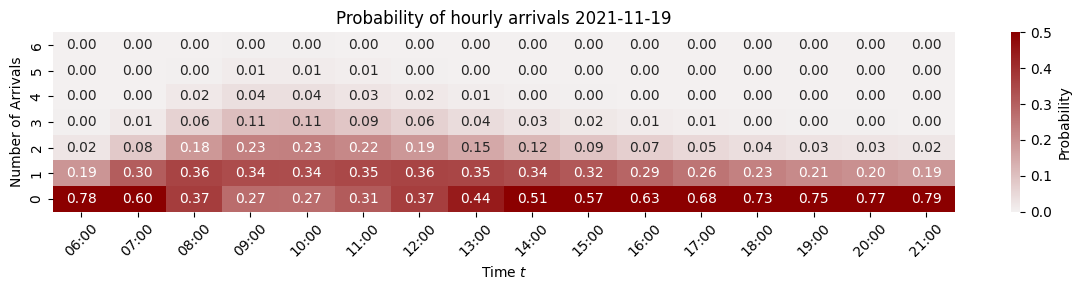

In [8]:
fig, ax = plt.subplots(1, 1, figsize=(12, 3))
ax = sns.heatmap(preds.T,
                 vmin=0,
                 vmax=0.5,
                 annot=True,
                 fmt='.2f',
                 cmap=sns.color_palette("light:darkred", as_cmap=True),
                 cbar_kws={'label': 'Probability'},
                 ax=ax)
ax.set_xticklabels(preds.index.strftime('%H:%M'))
# ax.xaxis.set_major_formatter(mdates.DateFormatter('%H:%M'))
plt.xticks(rotation=45)
ax.invert_yaxis()
ax.set_xlabel('Time $t$')
ax.set_ylabel('Number of Arrivals')
ax.set_title(f'Probability of hourly arrivals {str(anchor_time.date())}')
fig.tight_layout()


Z tohoto grafu lze například usuzovat, že mezi desátou a jedenáctou hodinou (sloupec 10:00) přijede 1 sanitka s pravděpodobností 34 %.
V tu samou hodinu lze například říci, že:
- přijede 1 až 3 sanitky s pravděpodobností (34 + 23 + 11) % = 68 %,
- s pravděpodobností (100 - 27) % = 73 % přijede jedna a více sanitek,
- na 11 % přijedou právě 3 sanitky.

## Frekvence příjezdů
Alternativně lze také zobrazovat skrytou proměnnou $\lambda(t)$ reprezentující střední frekvenci příjezdů sanitek za hodinu. Tato náhodná proměnná má také příslušný pás nejistoty naučený z poskytnutých dat.

In [4]:
rates_dist, index = ora.get_rates_distribution(to_future=5,
                          to_past=10,
                          now=anchor_time)
lower = rates_dist.icdf(torch.tensor(0.1))
mu = rates_dist.icdf(torch.tensor(0.5))
upper = rates_dist.icdf(torch.tensor(0.9))
eighty = rates_dist.icdf(torch.tensor(0.8))

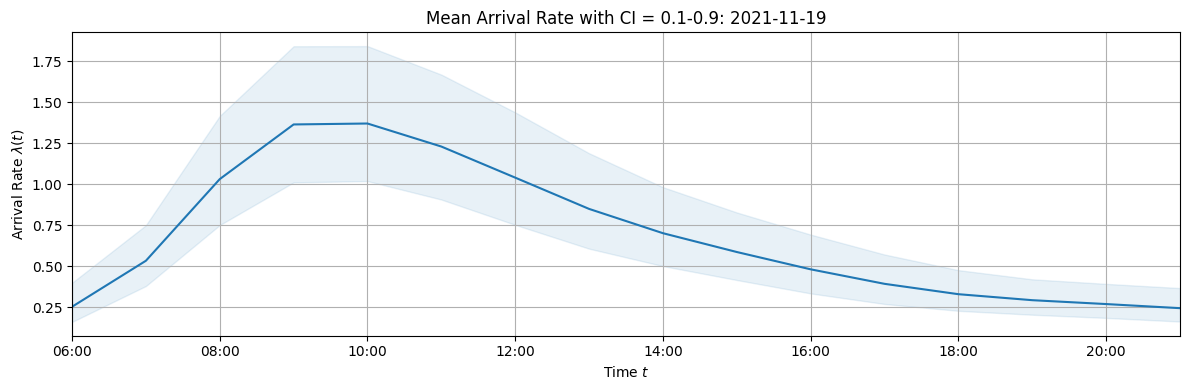

In [9]:
fig, ax_upper = plt.subplots(1, 1, figsize=(12, 4))
lineplot = ax_upper.plot(index, mu)
ax_upper.fill_between(
        index,
        lower,
        upper,
        color=lineplot[0].get_color(), alpha=0.1
    )
ax_upper.grid()
ax_upper.xaxis.set_major_formatter(mdates.DateFormatter('%H:%M'))
ax_upper.set_xlabel('Time $t$')
ax_upper.set_ylabel('Arrival Rate $\lambda(t)$')
ax_upper.set_xlim([index[0], index[-1]])
ax_upper.set_title(f'Mean Arrival Rate with CI = 0.1-0.9: {str(anchor_time.date())}')
fig.tight_layout()

Střední frekvence příchodů slouží jako spojitý odhad příchodů pacientů, který výše vstupuje jako parametr do Poissonova rozdělení.